In [22]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from joblib import dump,load
from sklearn.metrics import precision_recall_fscore_support as score
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

In [23]:
df = pd.read_json("./Video_Games_5.json", lines=True)
num_overall_1 = df["overall"].value_counts()[1]
print("Number of elements with overall 1:", num_overall_1)
num_overall_2 = df["overall"].value_counts()[2]
print("Number of elements with overall 2:", num_overall_2)
num_overall_3 = df["overall"].value_counts()[3]
print("Number of elements with overall 3:", num_overall_3)
num_overall_4 = df["overall"].value_counts()[4]
print("Number of elements with overall 4:", num_overall_4)
num_overall_5 = df["overall"].value_counts()[5]
print("Number of elements with overall 5:", num_overall_5)
num_class_0 = num_overall_1 + num_overall_2
num_class_2 = num_overall_4 + num_overall_5
weight_0 = num_class_2 / num_class_0
weight_1 = num_class_2 / num_overall_3
bayes_weight=[0.4,0.4,0.2]
svm_rf_weight={0:weight_0, 1: weight_1, 2:4}

Number of elements with overall 1: 30883
Number of elements with overall 2: 24135
Number of elements with overall 3: 49146
Number of elements with overall 4: 93654
Number of elements with overall 5: 299759


In [24]:
df["sentiment"] = df["overall"].apply(
    lambda rating: 0 if rating <= 2 else (1 if rating == 3 else 2)
)

In [25]:

df.fillna({"reviewText": ""}, inplace=True)

df["reviewText"] = df["reviewText"].apply(lambda x: re.sub(r"\W", " ", str(x)))

stop_words = set(stopwords.words("english"))
df["reviewText"] = df["reviewText"].apply(
    lambda x: " ".join([word for word in word_tokenize(x) if word not in stop_words])
)

stemmer = PorterStemmer()
df["reviewText"] = df["reviewText"].apply(
    lambda x: " ".join([stemmer.stem(word) for word in word_tokenize(x)])
)

In [26]:
vectorizer = TfidfVectorizer()
reviews_tfidf = vectorizer.fit_transform(df["reviewText"])

In [27]:
rus=RandomUnderSampler(random_state=42, sampling_strategy={2: 50000})
reviews_sampled, sentiments_sampled = rus.fit_resample(reviews_tfidf, df["sentiment"])

In [28]:
reviews_train, reviews_test, sentiments_train, sentiments_test = train_test_split(
    reviews_sampled, sentiments_sampled, test_size=0.2, random_state=42
)

Train accuracy:  0.6720532550615822
Test accuracy:  0.5843414523400253
              precision    recall  f1-score   support

           0       0.63      0.76      0.69     10894
           1       0.47      0.68      0.56      9892
           2       0.89      0.29      0.44     10047

    accuracy                           0.58     30833
   macro avg       0.66      0.58      0.56     30833
weighted avg       0.66      0.58      0.57     30833



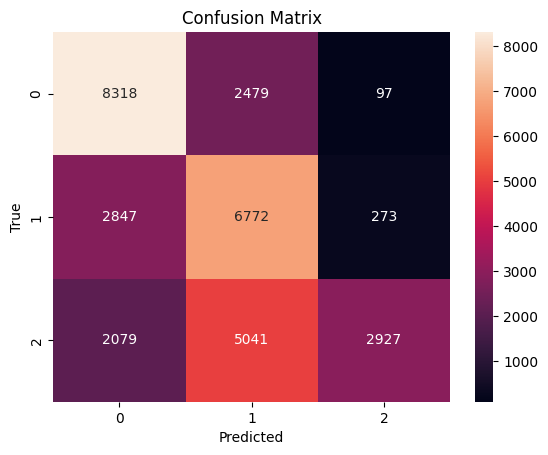

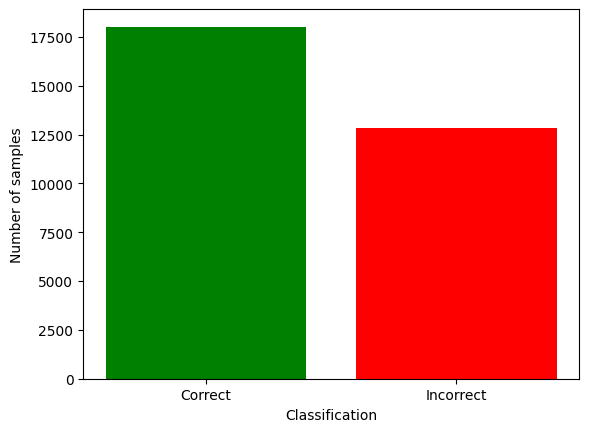

In [29]:
clf = RandomForestClassifier(n_estimators=300, max_depth=100, min_samples_leaf=5, min_samples_split=10, random_state=42, class_weight=svm_rf_weight)

clf.fit(reviews_train, sentiments_train)

dump(clf, 'random_forest_classifier_partition.joblib')
rf_loaded = load('random_forest_classifier_partition.joblib')

sentiments_pred = rf_loaded.predict(reviews_test)
train_accuracy = accuracy_score(sentiments_train, rf_loaded.predict(reviews_train))
test_accuracy = accuracy_score(sentiments_test, rf_loaded.predict(reviews_test))
print("Train accuracy: ", train_accuracy)
print("Test accuracy: ", test_accuracy)
print(classification_report(sentiments_test, sentiments_pred))

cm = confusion_matrix(sentiments_test, sentiments_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

correct = (sentiments_pred == sentiments_test).sum()
incorrect = (sentiments_pred != sentiments_test).sum()

results = {"Correct": correct, "Incorrect": incorrect}
plt.bar(results.keys(), results.values(), color=["green", "red"])
plt.xlabel("Classification")
plt.ylabel("Number of samples")
plt.show()

Train accuracy:  0.807639603992508
Test accuracy:  0.6650017838030682
              precision    recall  f1-score   support

           0       0.69      0.72      0.71     10894
           1       0.55      0.58      0.57      9892
           2       0.77      0.68      0.72     10047

    accuracy                           0.67     30833
   macro avg       0.67      0.66      0.67     30833
weighted avg       0.67      0.67      0.67     30833



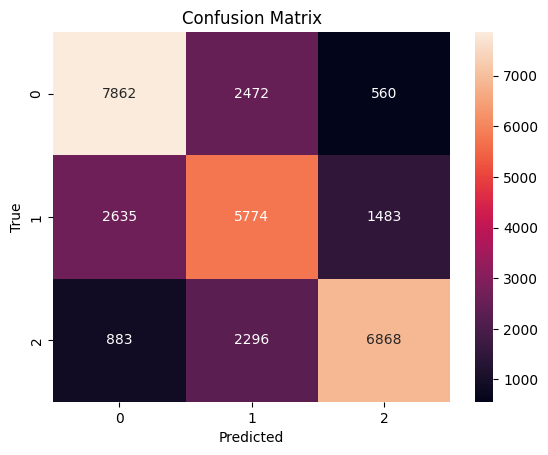

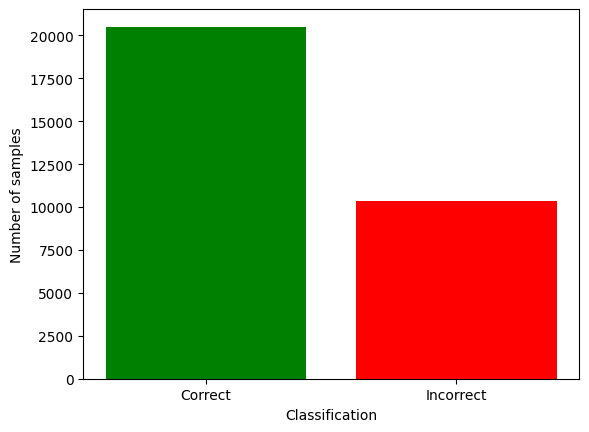

In [30]:
clf = LinearSVC(dual=True, max_iter=10000, class_weight=svm_rf_weight)

clf.fit(reviews_train, sentiments_train)

dump(clf, 'svm_partition.joblib')
# svm_loaded = load('svm.joblib')

sentiments_pred = clf.predict(reviews_test)
train_accuracy = accuracy_score(sentiments_train, clf.predict(reviews_train))
test_accuracy = accuracy_score(sentiments_test, clf.predict(reviews_test))
print("Train accuracy: ", train_accuracy)
print("Test accuracy: ", test_accuracy)
print(classification_report(sentiments_test, sentiments_pred))

cm = confusion_matrix(sentiments_test, sentiments_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

correct = (sentiments_pred == sentiments_test).sum()
incorrect = (sentiments_pred != sentiments_test).sum()

results = {"Correct": correct, "Incorrect": incorrect}
plt.bar(results.keys(), results.values(), color=["green", "red"])
plt.xlabel("Classification")
plt.ylabel("Number of samples")
plt.show()

              precision    recall  f1-score   support

           0       0.61      0.75      0.67     10894
           1       0.45      0.66      0.53      9892
           2       0.90      0.25      0.40     10047

    accuracy                           0.56     30833
   macro avg       0.65      0.55      0.53     30833
weighted avg       0.65      0.56      0.54     30833

Train accuracy:  0.5962329017035457
Test accuracy:  0.5576492718840204


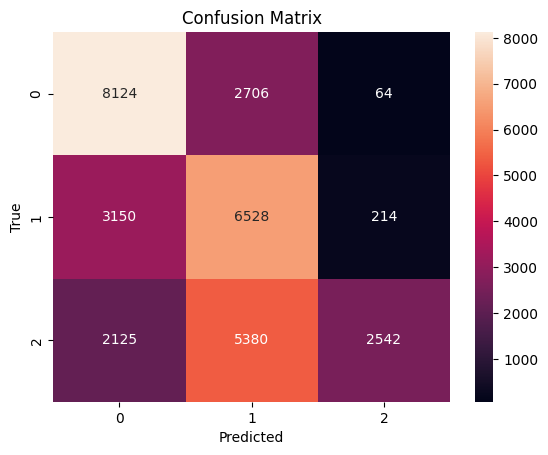

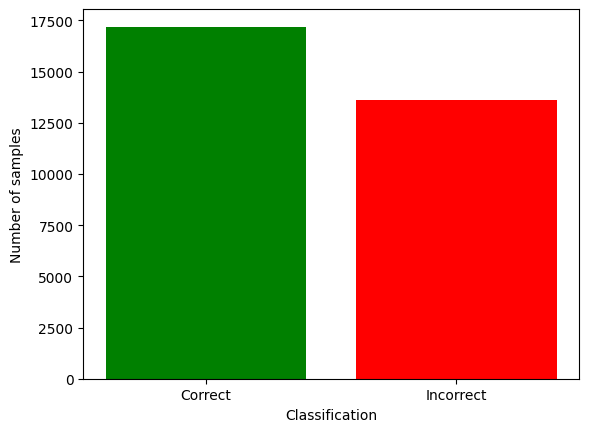

In [31]:
clf = MultinomialNB(class_prior=bayes_weight)
clf.fit(reviews_train, sentiments_train)
dump(clf, "bayes_partition.joblib")

# nb_loaded = load('bayes.joblib')
sentiments_pred = clf.predict(reviews_test)

print(classification_report(sentiments_test, sentiments_pred))

train_accuracy = accuracy_score(sentiments_train, clf.predict(reviews_train))
test_accuracy = accuracy_score(sentiments_test, clf.predict(reviews_test))
print("Train accuracy: ", train_accuracy)
print("Test accuracy: ", test_accuracy)

cm = confusion_matrix(sentiments_test, sentiments_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")


plt.show()

correct= (sentiments_pred == sentiments_test).sum()
incorrect = (sentiments_pred != sentiments_test).sum()

results={'Correct':correct, 'Incorrect':incorrect}
plt.bar(results.keys(), results.values(), color=['green', 'red'])
plt.xlabel('Classification')
plt.ylabel('Number of samples')
plt.show()

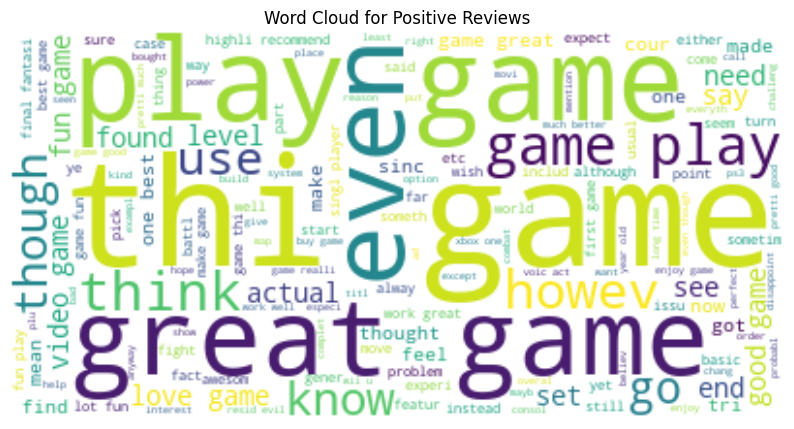

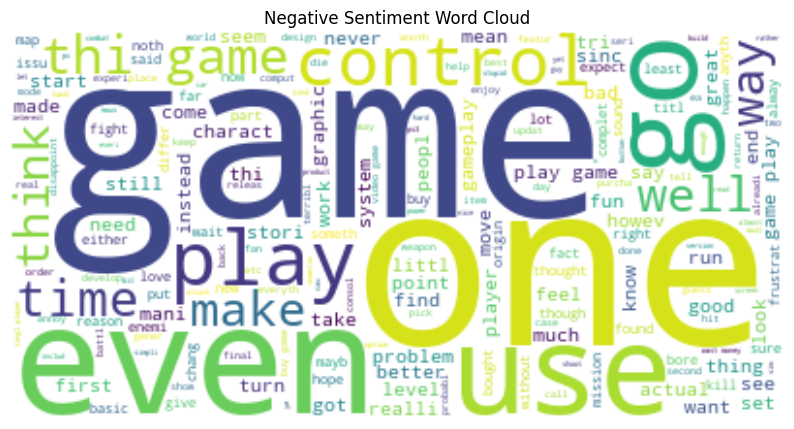

In [32]:
#WordCloud per sentimenti positivi
positive_reviews = df[df['sentiment'] == 2]['reviewText'].str.cat(sep=' ')
wordcloud = WordCloud(background_color='white', max_words=200).generate(positive_reviews)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Word Cloud per sentimenti negativi
negative_reviews = df[df['sentiment'] == 0]['reviewText'].str.cat(sep=' ')
wordcloud_negative = WordCloud(background_color='white', max_words=200, contour_color='red').generate(negative_reviews)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Word Cloud')
plt.show()

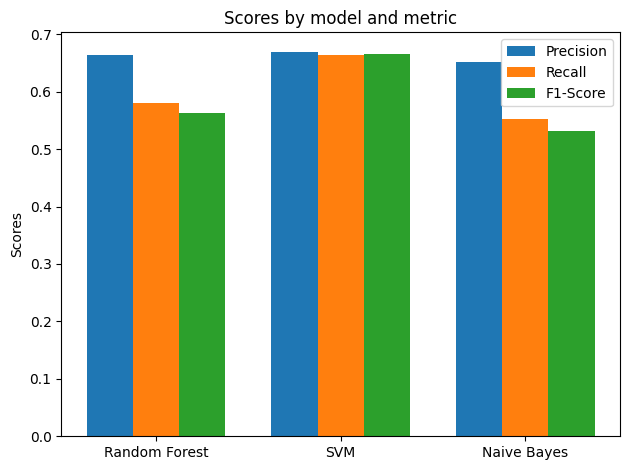

In [33]:
# Calcolo delle metriche per il confronto dei modelli
# Calcola metriche per Random Forest
svm_loaded = load('svm_partition.joblib')
nb_loaded = load('bayes_partition.joblib')
precision_rf, recall_rf, fscore_rf, _ = score(sentiments_test, rf_loaded.predict(reviews_test), average='macro')

# Calcola metriche per SVM
precision_svm, recall_svm, fscore_svm, _ = score(sentiments_test, svm_loaded.predict(reviews_test), average='macro')

# Calcola metriche per Naive Bayes
precision_nb, recall_nb, fscore_nb, _ = score(sentiments_test, nb_loaded.predict(reviews_test), average='macro')

# Creazione del grafico a barre per confrontare i modelli
models = ['Random Forest', 'SVM', 'Naive Bayes']
precision_scores = [precision_rf, precision_svm, precision_nb]
recall_scores = [recall_rf, recall_svm, recall_nb]
fscore_scores = [fscore_rf, fscore_svm, fscore_nb]

x = np.arange(len(models))  
width = 0.25  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision_scores, width, label='Precision')
rects2 = ax.bar(x, recall_scores, width, label='Recall')
rects3 = ax.bar(x + width, fscore_scores, width, label='F1-Score')

ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

fig.tight_layout()

plt.show()